In [754]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import textstat

from matplotlib import pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.svm import LinearSVC as SVC
from sklearn.utils import class_weight
from xgboost import XGBClassifier as XGBC

import tensorflow as tf
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, model_from_json

import pydot
import pydotplus
import graphviz

In [755]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = int(multiprocessing.cpu_count() -1)

In [756]:
%matplotlib inline

pd.set_option('display.max_colwidth', 200)

### Tools for Multiprocessing

In [102]:
def parallel_function_wrapper(my_function, parms_tuple):
        
    # call the given function according to the correct number of parameters
    if (parms_tuple[2] is not None) & (parms_tuple[3] is not None):
        result = my_function(parms_tuple[1], parms_tuple[2], parms_tuple[3]) 
    elif parms_tuple[2] is not None:
        result = my_function(parms_tuple[1], parms_tuple[2]) 
    else: 
        result = my_function(parms_tuple[1])     

    # return the input ID with the return values
    return_tuple = (parms_tuple[0], result)    
    return(return_tuple)

In [134]:
def parallelize_function(data, my_function, value_field, parameter_2 = None, parameter_3 = None):
    
    # prepare parameters for parallelized function call (including the row names for later sorting)
    data_list_with_row_names = list(data.apply(lambda x: (x.name, x[value_field], parameter_2, parameter_3),
                                               axis = 1))

    # prepare the progress bar
    inputs = tqdm(data_list_with_row_names)

    # execute the given function using multiprocessing
    if __name__ == "__main__":
        result = Parallel(n_jobs = num_cores)(delayed(parallel_function_wrapper)(my_function, value) for value in inputs)
    
    # sort the results using row names
    result_df = pd.DataFrame(result, columns = ('row_name', 'value'))
    result_df['row_name'] = result_df['row_name'].astype(int)
    result_df = result_df.sort_values(by = 'row_name') 
    
    return(result_df['value'].values)

## Load Data

In [760]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [761]:
train.shape

(159571, 8)

In [762]:
test.shape

(153164, 2)

In [763]:
test_labels.shape

(153164, 7)

In [764]:
train.isnull().sum().sum()

0

In [765]:
test.isnull().sum().sum()

0

In [766]:
test_labels.isnull().sum().sum()

0

In [767]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [768]:
train.comment_text

0         Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...
1                                                                                                D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
2         Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...
3         "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tid...
4                                                                                                                                             You, sir, are my h

In [769]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#label_columns = ['toxic']

num_labels = len(label_columns)

In [770]:
scored_y_test_indices = test_labels['toxic'].apply(lambda x: x != -1)

test = test[scored_y_test_indices].reset_index(drop = True)
test_labels = test_labels[scored_y_test_indices].reset_index(drop = True)

print(test.shape)
print(test_labels.shape)

(63978, 2)
(63978, 7)


In [771]:
train = train.drop('id', axis = 1).reset_index(drop = True)
test = test.drop('id', axis = 1).reset_index(drop = True)

### Languages

In [772]:
# from langdetect import DetectorFactory, detect
# from langdetect.lang_detect_exception import LangDetectException
# DetectorFactory.seed = 0

# def my_detect(text):
#     try:
#         return detect(text)
#     except LangDetectException:
#         return False

In [773]:
# skip_languages = ['False', 
#                  'ar', 'he',
#                  'bn', 'ur', 'hi', 'ta', 'te', 'pa', 'gu', 'ne', 'mr',
#                  'ru', 'uk', 'mk',
#                  'zh-tw', 'zh-cn', 'ja', 'kn', 'vi', 'th', 'ml',
#                  'id', 'tl',
#                  'tr'
#                 ]

In [774]:
#train_language_list = parallelize_function(train, my_detect, 'comment_text', None, None)

In [775]:
#test_language_list = parallelize_function(test, my_detect, 'comment_text', None, None)

In [776]:
#train_language_dummies = pd.get_dummies(train_language_list)
#test_language_dummies = pd.get_dummies(test_language_list)

In [777]:
#train = pd.concat([train, train_language_dummies], axis = 1)
#test = pd.concat([test, test_language_dummies], axis = 1)   

In [778]:
#text_feature_columns += list(train_language_dummies.columns)

### Profanity

In [779]:
import profanity_check

def my_profanity_check(string):
    return(profanity_check.predict_prob([string])[0])
    
train_profanity_list = parallelize_function(train, my_profanity_check, 'comment_text', None, None)
test_profanity_list = parallelize_function(test, my_profanity_check, 'comment_text', None, None)

  0%|          | 0/159571 [00:00<?, ?it/s]

my_profanity_check


  0%|          | 0/63978 [00:00<?, ?it/s]

my_profanity_check


In [780]:
train['profanity'] = train_profanity_list
test['profanity'] = test_profanity_list

## Text Features

In [781]:
text_feature_columns = [
    'num_character', 'num_word', 'num_number',
    'num_uppercase', 'num_asterisk', 'num_bang', 'num_question',
    'reading_ease', 'grade_level',
    'negative_sentiment']

In [782]:
text_feature_columns += ['profanity']

In [783]:
# TO DO: num stop words
def add_text_features(comments):

    #----- language
    
#     comments['detect_language'] = parallelize_function(comments, my_detect, 'comment_text', None, None)
#     comments['is_skip'] = comments['detect_language'].isin(skip_languages)
#     comments['is_english'] = comments['detect_language'].apply(lambda x: x == 'en')
    
    #-----
    
    # number of characters
    comments['num_character'] = comments['comment_text'].str.len()

    # number of words
    comments['num_word'] = comments['comment_text'].str.split().str.len()
    
    # number of upper-case letters 
    comments['num_uppercase'] = comments['comment_text'].str.findall(r'[A-Z]').str.len()     

    # number of asterisks
    comments['num_asterisk'] = comments['comment_text'].str.findall(r'[*]').str.len()
    
    # number of exclamation marks
    comments['num_bang'] = comments['comment_text'].str.findall(r'[!]').str.len()
    
    # number of question marks
    comments['num_question'] = comments['comment_text'].str.findall(r'[?]').str.len()  
    
    # number of numbers
    comments['num_number'] = comments['comment_text'].str.findall(r'[0-9]').str.len()  
    
    #----- text analysis
    
    # reading ease
    comments['reading_ease'] = parallelize_function(comments, textstat.flesch_reading_ease, 'comment_text', None, None)
    comments['reading_ease'] = comments['reading_ease'].astype(float)
    
    # grade level    
    comments['grade_level'] = parallelize_function(comments, textstat.flesch_kincaid_grade, 'comment_text', None, None)
    comments['grade_level'] = comments['grade_level'].astype(float)
    
    #----- sentiment analysis
    
    sia = SentimentIntensityAnalyzer()

    my_lambda = lambda x: sia.polarity_scores(x)['neg']
    comments['negative_sentiment'] = parallelize_function(comments, my_lambda, 'comment_text', None, None)
    comments['negative_sentiment'] = comments['negative_sentiment'].astype(float)
    
    return(comments)

In [784]:
train = add_text_features(train)
test = add_text_features(test)

  0%|          | 0/159571 [00:00<?, ?it/s]

flesch_reading_ease


  0%|          | 0/159571 [00:00<?, ?it/s]

flesch_kincaid_grade


  0%|          | 0/159571 [00:00<?, ?it/s]

<lambda>


  0%|          | 0/63978 [00:00<?, ?it/s]

flesch_reading_ease


  0%|          | 0/63978 [00:00<?, ?it/s]

flesch_kincaid_grade


  0%|          | 0/63978 [00:00<?, ?it/s]

<lambda>


### Character Counts

In [785]:
# fig, axes = plt.subplots(3, 2, figsize = (30, 20))
# fig.suptitle('Labels')

# for i in range(len(label_columns)):
#     ax = axes[i // 2, i % 2]
#     sns.barplot(x = label_columns[i], y = 'num_character', data = train, estimator = np.mean, ax = ax)
#     ax.set_xlabel(label_columns[i], fontsize = 20)

# plt.show()

### Reading Ease

In [786]:
# fig, axes = plt.subplots(3, 2, figsize = (30, 20))
# fig.suptitle('Labels')

# for i in range(len(label_columns)):
#     ax = axes[i // 2, i % 2]
#     sns.barplot(x = label_columns[i], y = 'reading_ease', data = train, estimator = np.mean, ax = ax)
#     ax.set_xlabel(label_columns[i], fontsize = 20)

# plt.show()

### Upper-case Characters

In [787]:
# fig, axes = plt.subplots(3, 2, figsize = (30, 20))
# fig.suptitle('Labels')

# for i in range(len(label_columns)):
#     ax = axes[i // 2, i % 2]
#     sns.barplot(x = label_columns[i], y = 'upper_characters', data = train, estimator = np.mean, ax = ax)
#     ax.set_xlabel(label_columns[i], fontsize = 20)

# plt.show()

### Sentiment Polarity

In [788]:
# fig, axes = plt.subplots(3, 2, figsize = (30, 20))
# fig.suptitle('Labels')

# for i in range(len(label_columns)):
#     ax = axes[i // 2, i % 2]
#     sns.barplot(x = label_columns[i], y = 'sentiment_polarity', data = train, estimator = np.mean, ax = ax)
#     ax.set_xlabel(label_columns[i], fontsize = 20)

# plt.show()

In [789]:
# convert label values to numeric

train[label_columns] = train[label_columns].applymap(lambda x: pd.to_numeric(x))
test_labels[label_columns] = test_labels[label_columns].applymap(lambda x: pd.to_numeric(x))

In [790]:
train[text_feature_columns] = train[text_feature_columns].applymap(lambda x: pd.to_numeric(x))
test[text_feature_columns] = test[text_feature_columns].applymap(lambda x: pd.to_numeric(x))

In [791]:
X_train = train
X_test = test

#y_train = train[label_columns].values.reshape(-1, )
#y_test = test_labels[label_columns].values.reshape(-1, )

y_train = train[label_columns].values
y_test = test_labels[label_columns].values

In [792]:
X_train_char = train[text_feature_columns]
X_test_char = test[text_feature_columns]

In [793]:
from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()
my_scaler.fit(X_train_char)

X_train_char = my_scaler.transform(X_train_char)
X_test_char = my_scaler.transform(X_test_char)

In [794]:
y_train = train[label_columns[0]].values.reshape(-1, 1)
y_test = test_labels[label_columns[0]].values.reshape(-1, 1)

## Baseline Model

In [795]:
baseline_predictions = np.zeros(y_test.shape)

In [796]:
all_scores_baseline = pd.DataFrame()

for i in range(y_test.shape[1]):
    this_predict_proba = baseline_predictions[:, i] 
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'accuracy' : [round(accuracy_score(y_test[:, i], this_predict_proba), 4)],
        'F1' : [round(f1_score(y_test[:, i], this_predict_proba), 4)],
        'ROC AUC' : [round(roc_auc_score(y_test[:, i], this_predict_proba), 4)]
    })
    all_scores_baseline = pd.concat([all_scores_baseline, this_roc_auc_score], axis = 0)

In [797]:
all_scores_baseline.reset_index(drop = True)

,column,accuracy,F1,ROC AUC
0,toxic,0.9048,0.0,0.5


In [798]:
print('Mean accuracy: ' + str(round(all_scores_baseline['accuracy'].mean(), 4)))
print('Mean F1: ' + str(round(all_scores_baseline['F1'].mean(), 4)))
print('Mean ROC AUC: ' + str(round(all_scores_baseline['ROC AUC'].mean(), 4)))

Mean accuracy: 0.9048
Mean F1: 0.0
Mean ROC AUC: 0.5


## Gradient Boosting

### Cross-validate

In [799]:
best_n_estimators = 100
best_max_depth = 2
best_learning_rate = 0.3

In [800]:
cv_xgbc = XGBC(n_jobs = num_cores, 
               eval_metric = 'logloss',
               use_label_encoder = False,
               n_estimators = best_n_estimators, 
               max_depth = best_max_depth,
               learning_rate = best_learning_rate)

In [801]:
cv_result = cross_val_score(estimator = cv_xgbc, 
                            X = X_train_char, 
                            y = y_train,
                           cv = 3,
                           n_jobs = num_cores,
                           scoring = 'roc_auc',
                           verbose = 1)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of   3 | elapsed:    1.5s finished


In [802]:
round(cv_result.mean(), 4)

0.991

In [803]:
cv_xgbc.fit(X_train_char, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=15,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

### Grid Search Cross-validation

In [422]:
my_params_xgbc = {
    'n_estimators' : [25, 50, 100],
    'max_depth' : [2, 4, 6],
    'learning_rate' : [0.1, 0.2, 0.3]
}

In [423]:
search_xgbc = XGBC(n_jobs = num_cores, eval_metric = 'logloss', use_label_encoder = False)
searcher_xgbc = GridSearchCV(estimator = search_xgbc, param_grid = my_params_xgbc, n_jobs = num_cores, cv = 3,
                            scoring = 'roc_auc', verbose = 1)
searcher_xgbc.fit(X = X_train_char, y = y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=15,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=No

In [424]:
searcher_xgbc.best_score_

0.9910436345290171

In [425]:
searcher_xgbc.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}

In [433]:
my_params_xgbc_2 = {
    'n_estimators' : [100, 125, 150],
    'max_depth' : [2, 3, 4],
    'learning_rate' : [0.3, 0.35, 0.40]
}

In [434]:
search_xgbc_2 = XGBC(n_jobs = num_cores, eval_metric = 'logloss', use_label_encoder = False)
searcher_xgbc_2 = GridSearchCV(estimator = search_xgbc_2, param_grid = my_params_xgbc_2, n_jobs = num_cores, cv = 3,
                              scoring = 'roc_auc', verbose = 1)
searcher_xgbc_2.fit(X = X_train_char, y = y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=15,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=No

In [435]:
searcher_xgbc_2.best_score_

0.9910436345290171

In [436]:
searcher_xgbc_2.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}

### Test

In [804]:
xgbc_predict = cv_xgbc.predict(X_test_char).reshape(-1, 1)
xgbc_predict_proba = cv_xgbc.predict_proba(X_test_char)

In [807]:
this_score = pd.DataFrame({
    'column' : [label_columns[0]],
    'accuracy' : [round(accuracy_score(y_test, xgbc_predict), 4)],
    'ROC AUC' : [round(roc_auc_score(y_test, xgbc_predict_proba[:, 1]), 4)]
})
this_score

,column,accuracy,ROC AUC
0,toxic,0.91,0.9586


## Logistic Regression

### Cross-validate

In [808]:
best_C = 1

In [809]:
cv_log_reg = LogReg(C = best_C,
                     n_jobs = num_cores,
                   class_weight = 'balanced')

In [810]:
cv_result = cross_val_score(estimator = cv_log_reg, 
                            X = X_train_char, 
                            y = y_train,
                            cv = 3,
                            n_jobs = num_cores,
                           scoring = 'roc_auc',
                           verbose = 1)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of   3 | elapsed:    0.3s finished


In [811]:
round(cv_result.mean(), 4)

0.9898

In [812]:
cv_log_reg.fit(X_train_char, y_train)

C:\Users\dmodj\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=1, class_weight='balanced', n_jobs=15)

### Grid Search Cross-validation

In [170]:
my_params_log_reg = {
    'C' : np.arange(1, 11)
}

In [171]:
search_log_reg = LogReg(n_jobs = num_cores, class_weight = 'balanced')
searcher_log_reg = GridSearchCV(estimator = search_log_reg, param_grid = my_params_log_reg, n_jobs = num_cores, cv = 3,
                               scoring = 'roc_auc', verbose = 1)
searcher_log_reg.fit(X = X_train_char, y = y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=15),
             n_jobs=15,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='roc_auc', verbose=1)

In [172]:
searcher_log_reg.best_score_

0.9897899542095109

In [173]:
searcher_log_reg.best_params_

{'C': 1}

### Test

In [813]:
log_reg_predict = cv_log_reg.predict(X_test_char).reshape(-1, 1)
log_reg_predict_proba = cv_log_reg.predict_proba(X_test_char)

In [814]:
this_score = pd.DataFrame({
    'column' : [label_columns[0]], 
    'accuracy' : [round(accuracy_score(y_test, log_reg_predict), 4)],    
    'ROC AUC' : [round(roc_auc_score(y_test, log_reg_predict_proba[:, 1]), 4)]
})
this_score

,column,accuracy,ROC AUC
0,toxic,0.8834,0.956


## Random Forest

### Cross-validate

In [815]:
best_n_estimators = 125
best_max_depth = 10

In [816]:
cv_rfc = RFC(n_estimators = best_n_estimators,
             max_depth = best_max_depth,
             n_jobs = num_cores)

In [817]:
cv_result = cross_val_score(estimator = cv_rfc,
                            X = X_train_char, 
                            y = y_train,
                            cv = 3,
                            n_jobs = num_cores,
                           scoring = 'roc_auc',
                           verbose = 1)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of   3 | elapsed:   10.9s finished


In [818]:
round(cv_result.mean(), 4)

0.9897

In [819]:
cv_rfc.fit(X_train_char, y_train)

<ipython-input-819-4f759b4ae8fc>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cv_rfc.fit(X_train_char, y_train)


RandomForestClassifier(max_depth=10, n_estimators=125, n_jobs=15)

### Grid Search Cross-validation

In [449]:
my_params_rfc = {
    'n_estimators' : [50, 100, 150],
    'max_depth' : [10, 100, None]
}

In [451]:
search_rfc = RFC(n_jobs = num_cores)
searcher_rfc = GridSearchCV(estimator = search_rfc, param_grid = my_params_rfc, n_jobs = num_cores, cv = 3,
                           scoring = 'roc_auc', verbose = 1)
searcher_rfc.fit(X = X_train_char, y = y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=15), n_jobs=15,
             param_grid={'max_depth': [10, 100, None],
                         'n_estimators': [50, 100, 150]},
             scoring='roc_auc', verbose=1)

In [452]:
searcher_rfc.best_score_

0.9897584939680132

In [453]:
searcher_rfc.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [465]:
my_params_rfc_2 = {
    'n_estimators' : [75, 100, 125],
    'max_depth' : [10, 30, 50]
}

In [466]:
search_rfc_2 = RFC(n_jobs = num_cores)
searcher_rfc_2 = GridSearchCV(estimator = search_rfc_2, param_grid = my_params_rfc_2, n_jobs = num_cores, cv = 3,
                             scoring = 'roc_auc', verbose = 1)
searcher_rfc_2.fit(X = X_train_char, y = y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=15), n_jobs=15,
             param_grid={'max_depth': [10, 30, 50],
                         'n_estimators': [75, 100, 125]},
             scoring='roc_auc', verbose=1)

In [467]:
searcher_rfc_2.best_score_

0.9896246735241037

In [468]:
searcher_rfc_2.best_params_

{'max_depth': 10, 'n_estimators': 125}

### Test

In [820]:
rfc_predict = cv_rfc.predict(X_test_char).reshape(-1, 1)
rfc_predict_proba = cv_rfc.predict_proba(X_test_char)

In [821]:
this_score = pd.DataFrame({
    'column' : [label_columns[0]], 
    'accuracy' : [round(accuracy_score(y_test, rfc_predict), 4)],    
    'ROC AUC' : [round(roc_auc_score(y_test, rfc_predict_proba[:, 1]), 4)]
})
this_score

,column,accuracy,ROC AUC
0,toxic,0.9084,0.9566


## SVC

### Cross-validate

In [822]:
best_c = 0.01

In [823]:
from sklearn.calibration import CalibratedClassifierCV

cv_svc_0 = SVC(C = best_c,
              random_state = 43)
cv_svc = CalibratedClassifierCV(cv_svc_0,
                               n_jobs = num_cores) 

In [824]:
cv_result = cross_val_score(estimator = cv_svc,
                            X = X_train_char, 
                            y = y_train,
                            cv = 3,
                            n_jobs = num_cores,
                           scoring = 'roc_auc',
                           verbose = 1)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of   3 | elapsed:   29.3s finished


In [825]:
round(cv_result.mean(), 4)

0.99

In [826]:
cv_svc.fit(X_train_char, y_train)

C:\Users\dmodj\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


CalibratedClassifierCV(base_estimator=LinearSVC(C=0.01, random_state=43),
                       n_jobs=15)

### Test

In [827]:
svc_predict = cv_svc.predict(X_test_char).reshape(-1, 1)
svc_predict_proba = cv_svc.predict_proba(X_test_char)

In [828]:
this_score = pd.DataFrame({
    'column' : [label_columns[0]], 
    'accuracy' : [round(accuracy_score(y_test, xgbc_predict), 4)],    
    'ROC AUC' : [round(roc_auc_score(y_test, svc_predict_proba[:, 1]), 4)]
})
this_score

,column,accuracy,ROC AUC
0,toxic,0.91,0.957


## Ensemble

### Cross-validate

In [829]:
cv_ensemble = VotingClassifier(estimators = [('xgbc', cv_xgbc), 
                                             ('log_reg', cv_log_reg), 
                                             ('svc', cv_svc),
                                             ('rfc', cv_rfc)],
                               voting = 'soft')

In [830]:
cv_result = cross_val_score(estimator = cv_ensemble, 
                            X = X_train_char, 
                            y = y_train,
                            cv = 3,
                            n_jobs = num_cores,
                           scoring = 'roc_auc',
                           verbose = 1)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of   3 | elapsed:   39.1s finished


In [831]:
round(cv_result.mean(), 4)

0.9908

In [832]:
cv_ensemble.fit(X_train_char, y_train)

C:\Users\dmodj\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


VotingClassifier(estimators=[('xgbc',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            eval_metric='logloss', gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.3, max_delta_step=0,
                                            max_depth=2, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=10...
                                            scale_pos_weight=1, subsample=1,
                                      

### Test

In [833]:
ensemble_predict = cv_ensemble.predict(X_test_char).reshape(-1, 1)
ensemble_predict_proba = cv_ensemble.predict_proba(X_test_char)

In [834]:
this_score = pd.DataFrame({
    'column' : [label_columns[0]], 
    'accuracy' : [round(accuracy_score(y_test, xgbc_predict), 4)],    
    'ROC AUC' : [round(roc_auc_score(y_test, ensemble_predict_proba[:, 1]), 4)]
})
this_score

,column,accuracy,ROC AUC
0,toxic,0.91,0.9584


## MLP

In [835]:
y_train = train[label_columns].values
y_test = test_labels[label_columns].values

In [836]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizer_v2.adam import Adam

In [837]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_char)
X_train_mlp = scaler.transform(X_train_char)
X_test_mlp = scaler.transform(X_test_char)

In [838]:
input_dim = X_train_mlp.shape[1]
nb_classes = y_train.shape[1]

In [859]:
regularization_level = 0.1

model = Sequential()
model.add(Dense(16, input_dim = input_dim, activation = 'relu', 
                kernel_regularizer=keras.regularizers.l2(l = regularization_level)))
#model.add(Dropout(0.1))
model.add(Dense(16, input_dim = input_dim, activation = 'relu', 
                kernel_regularizer=keras.regularizers.l2(l = regularization_level)))
#model.add(Dropout(0.1))
model.add(Dense(nb_classes, activation = 'sigmoid'))

In [860]:
opt = Adam(learning_rate = 1E-4)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy', 'AUC'])

model.summary()

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_314 (Dense)            (None, 16)                192       
_________________________________________________________________
dense_315 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_316 (Dense)            (None, 6)                 102       
Total params: 566
Trainable params: 566
Non-trainable params: 0
_________________________________________________________________


In [861]:
print("Training...")
history = model.fit(X_train_mlp, y_train, epochs = 3, batch_size = 32, validation_split = 0.2, verbose = 'auto')

Training...
Epoch 1/3
3990/3990 [==============================] - 21s 5ms/step - loss: 2.1090 - accuracy: 0.8814 - auc: 0.8343 - val_loss: 1.6196 - val_accuracy: 0.9941 - val_auc: 0.9690
Epoch 2/3
3990/3990 [==============================] - 20s 5ms/step - loss: 2.7195 - accuracy: 0.9948 - auc: 0.9538 - val_loss: 7.5453 - val_accuracy: 0.9941 - val_auc: 0.9215
Epoch 3/3
3990/3990 [==============================] - 21s 5ms/step - loss: 9.8761 - accuracy: 0.9931 - auc: 0.9232 - val_loss: 18.2221 - val_accuracy: 0.9883 - val_auc: 0.9142


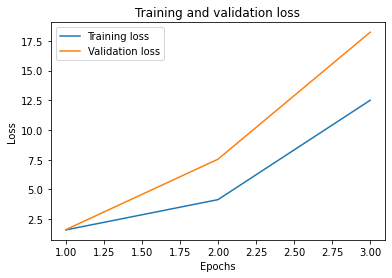

In [862]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show();

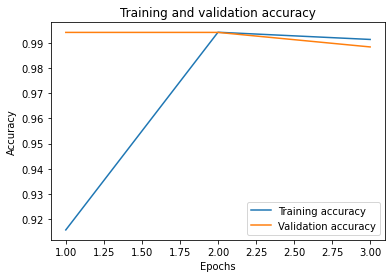

In [863]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show();

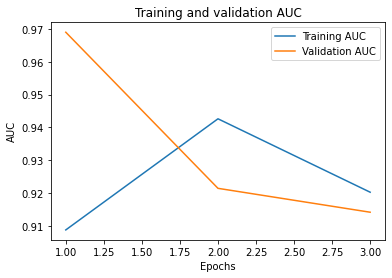

In [864]:
accuracy = history.history['auc']
val_accuracy = history.history['val_auc']

plt.plot(epochs, accuracy, label='Training AUC')
plt.plot(epochs, val_accuracy, label='Validation AUC')

plt.title('Training and validation AUC')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend()

plt.show();

In [865]:
print("Generating test predictions...")
predict_prob_test_dl = model.predict(X_test_mlp) 

Generating test predictions...


In [866]:
all_scores_dl = pd.DataFrame()

for i in range(nb_classes):
    this_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test[:, i], predict_prob_test_dl[:, i]), 4)]
    })
    
    all_scores_dl = pd.concat([all_scores_dl, this_score], axis = 0)

all_scores_dl.reset_index(drop = True, inplace = True)

In [867]:
all_predictions_dl = [None] * num_labels
all_roc_auc_scores_dl = pd.DataFrame()

print('PREDICT')

for i in range(nb_classes):
    print('Label ' + str(i))
    
    #this_predict_proba = predict_prob_test_dl[:, i]
    this_predict_proba = predict_prob_test_dl[:, 0]
    all_predictions_dl[i] = this_predict_proba
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test[:, i], this_predict_proba), 4)]
    })
    all_roc_auc_scores_dl = pd.concat([all_roc_auc_scores_dl, this_roc_auc_score], axis = 0)

PREDICT
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [868]:
all_roc_auc_scores_dl.reset_index(drop = True)

,column,ROC AUC
0,toxic,0.9052
1,severe_toxic,0.9200
2,obscene,0.9225
3,threat,0.9040
4,insult,0.9171
5,identity_hate,0.8929


In [869]:
print(round(all_scores_dl['ROC AUC'].mean(), 4))

0.9156
